In [1]:
using Plots
using LES_ML
using LaTeXStrings
using CUDA
using Distributions

In [2]:
N = (256,256)
UPC = 2       


x= collect(LinRange(-pi,pi,N[1]+1))
y = collect(LinRange(-pi,pi,N[2]+1))

fine_mesh = gen_mesh(x,y,UPC = UPC,use_GPU = false)

# number of unknowns per cell

J = (4,4) # compression in each direction
coarse_mesh = gen_coarse_from_fine_mesh(fine_mesh,J)
MP = gen_mesh_pair(fine_mesh,coarse_mesh)
0

FA_filter = gen_FA_filter(J,2) #|> gpu


┌ Info: The CUDA function is being called but CUDA.jl is not functional.
└ Defaulting back to the CPU. (No action is required if you want to run on the CPU).
┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = ConvTranspose((4, 4), 2 => 2, stride=4, bias=false)  # 64 parameters
│   summary(x) = "64×64×2×1 Array{Float64, 4}"
└ @ Flux ~/.julia/packages/Flux/MtsAN/src/layers/stateless.jl:60


Conv((4, 4), 2 => 2, stride=4, bias=false)  # 64 parameters

In [3]:
forcing(x) = sin.(4*x[2])

F = fine_mesh.eval_function(forcing)
F = cat(F,zeros(size(F)),dims = fine_mesh.dims + 1)



256×256×2×1 Array{Float64, 4}:
[:, :, 1, 1] =
 0.0490677  0.14673  0.24298  0.33689  …  -0.24298  -0.14673  -0.0490677
 0.0490677  0.14673  0.24298  0.33689     -0.24298  -0.14673  -0.0490677
 0.0490677  0.14673  0.24298  0.33689     -0.24298  -0.14673  -0.0490677
 0.0490677  0.14673  0.24298  0.33689     -0.24298  -0.14673  -0.0490677
 0.0490677  0.14673  0.24298  0.33689     -0.24298  -0.14673  -0.0490677
 0.0490677  0.14673  0.24298  0.33689  …  -0.24298  -0.14673  -0.0490677
 0.0490677  0.14673  0.24298  0.33689     -0.24298  -0.14673  -0.0490677
 0.0490677  0.14673  0.24298  0.33689     -0.24298  -0.14673  -0.0490677
 0.0490677  0.14673  0.24298  0.33689     -0.24298  -0.14673  -0.0490677
 0.0490677  0.14673  0.24298  0.33689     -0.24298  -0.14673  -0.0490677
 0.0490677  0.14673  0.24298  0.33689  …  -0.24298  -0.14673  -0.0490677
 0.0490677  0.14673  0.24298  0.33689     -0.24298  -0.14673  -0.0490677
 0.0490677  0.14673  0.24298  0.33689     -0.24298  -0.14673  -0.0490677
 ⋮   

In [4]:
setup = gen_setup(fine_mesh)
setup_bar = gen_setup(coarse_mesh)

LES_ML.setup_struct(LES_ML.operators_struct(Conv((3, 3), 2 => 1, bias=false), Conv((3, 3), 1 => 2, bias=false), LES_ML.var"#C#86"{Float64, Int64}(0.0981747704246807, Core.Box(Conv((3, 3), 2 => 4, bias=false)), Core.Box(Conv((3, 3), 2 => 4, bias=false)), 2, Core.Box(Conv((3, 3), 4 => 2, bias=false))), Conv((3, 3), 2 => 2, bias=false), Conv((3, 3), 2 => 1, bias=false)), LES_ML.var"#pressure_poisson#40"{LES_ML.var"#pressure_poisson#32#41", Array{Float64, 4}}(LES_ML.var"#pressure_poisson#32#41"(Core.Box(2)), Core.Box([0.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]), [1.0 0.999196986919884 … 3.9871651344789143 0.999196986919884; 0.999196986919884 1.998393973839768 … 4.986362121398798 1.998393973839768; … ; 3.9871651344789143 4.986362121398798 … 7.974330268957829 4.986362121398798; 0.999196986919884 1.998393973839768 … 4.986362121398798 1.998393973839768;;;;]), LES_ML.grid_swapper(LES_ML.mesh_struct(2, (64, 64), [-3.0925052683774528 -3.0925052683774528 … -3.0

In [5]:
max_k = 10
energy_norm = 1
number_of_simulations = 1
Re =1000



setup = gen_setup(fine_mesh)
setup_bar = gen_setup(coarse_mesh)
KF_rhs = gen_rhs(setup,F;Re = Re,damping = 0.0)

V = gen_random_field(fine_mesh.N,max_k,norm = energy_norm,samples = (fine_mesh.UPC,number_of_simulations))


    
MV = setup.O.M(padding(V,(1,1),circular = true))



p = setup.PS(MV)

Gp = setup.O.G(padding(p,(1,1),circular =true))

V0 = V-Gp

setup.O.M(V0)[:,:,1,1]

KF_rhs(V0,fine_mesh,0)


256×256×2×1 Array{Float64, 4}:
[:, :, 1, 1] =
 3.13729  4.04374  4.84572  5.51397  …  0.152468    1.1523    2.16076
 3.11601  4.04511  4.8651   5.54596     0.0452682   1.07554   2.11304
 3.11691  4.05011  4.86873  5.5426      0.00530876  1.05342   2.10474
 3.13161  4.05067  4.84946  5.49829     0.0261874   1.07808   2.12746
 3.14908  4.03729  4.7997   5.40782     0.0965993   1.13797   2.16959
 3.15692  3.99968  4.71197  5.26704  …  0.20139     1.21793   2.21695
 3.14192  3.92759  4.5797   5.07317     0.322519    1.30071   2.25404
 3.09088  3.81183  4.39775  4.82565     0.440352    1.36828   2.26476
 2.99274  3.64488  4.16305  4.52604     0.534532    1.40244   2.23425
 2.83794  3.422    3.87546  4.17857     0.585938    1.38678   2.14909
 2.62053  3.14133  3.53757  3.79057  …  0.577208    1.30717   1.99936
 2.33794  2.80472  3.15523  3.37152     0.494443    1.15329   1.77823
 1.9917   2.41724  2.73724  2.93355     0.327675    0.918787  1.48327
 ⋮                                   ⋱      

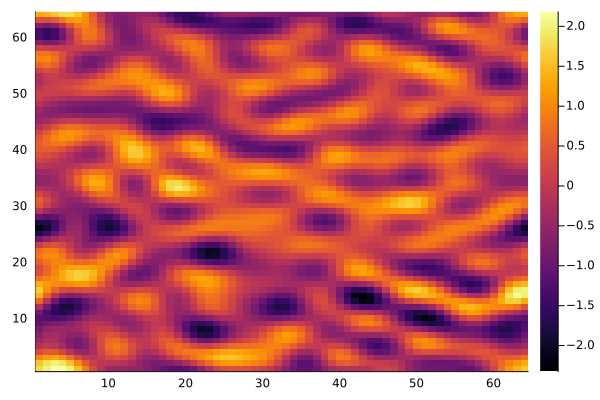

In [6]:
heatmap(Array(FA_filter(V0))[:,:,2,1])

In [7]:
dt = 0.01
save_every = 100
t_start = 0
t_end = 50
pre_allocate = true

t_data,sim_data = simulate(V0,fine_mesh,dt,t_start,t_end,KF_rhs,save_every = save_every,pre_allocate = pre_allocate) 
0

0.0%┣                                         ┫ 0/5.0k [00:01<-1:-53:00, -1s/it]
0.0%┣                                         ┫ 1/5.0k [00:02<Inf:Inf, InfGs/it]
0.0%┣                                           ┫ 2/5.0k [00:03<03:47:37, 3s/it]
0.1%┣                                           ┫ 3/5.0k [00:03<01:56:28, 1s/it]
0.1%┣                                           ┫ 4/5.0k [00:03<01:19:33, 1it/s]
0.1%┣                                           ┫ 5/5.0k [00:03<01:01:08, 1it/s]
0.1%┣                                              ┫ 6/5.0k [00:03<50:05, 2it/s]
0.1%┣                                              ┫ 7/5.0k [00:03<42:43, 2it/s]
0.2%┣                                              ┫ 8/5.0k [00:03<37:27, 2it/s]
0.2%┣                                              ┫ 9/5.0k [00:03<33:34, 2it/s]
0.2%┣                                             ┫ 10/5.0k [00:03<30:29, 3it/s]
0.2%┣                                             ┫ 11/5.0k [00:03<28:02, 3it/s]
0.2%┣                       

2.0%┣▉                                          ┫ 102/5.0k [00:10<08:14, 10it/s]
2.1%┣▉                                          ┫ 103/5.0k [00:10<08:13, 10it/s]
2.1%┣█                                          ┫ 104/5.0k [00:10<08:11, 10it/s]
2.1%┣█                                          ┫ 105/5.0k [00:10<08:09, 10it/s]
2.1%┣█                                          ┫ 106/5.0k [00:10<08:07, 10it/s]
2.1%┣█                                          ┫ 107/5.0k [00:11<08:06, 10it/s]
2.2%┣█                                          ┫ 108/5.0k [00:11<08:04, 10it/s]
2.2%┣█                                          ┫ 109/5.0k [00:11<08:02, 10it/s]
2.2%┣█                                          ┫ 110/5.0k [00:11<08:01, 10it/s]
2.2%┣█                                          ┫ 111/5.0k [00:11<08:00, 10it/s]
2.2%┣█                                          ┫ 112/5.0k [00:11<07:58, 10it/s]
2.3%┣█                                          ┫ 113/5.0k [00:11<07:57, 10it/s]
2.3%┣█                      

4.1%┣█▊                                         ┫ 204/5.0k [00:17<06:50, 12it/s]
4.1%┣█▊                                         ┫ 205/5.0k [00:17<06:49, 12it/s]
4.1%┣█▊                                         ┫ 206/5.0k [00:17<06:49, 12it/s]
4.1%┣█▉                                         ┫ 207/5.0k [00:18<06:48, 12it/s]
4.2%┣█▉                                         ┫ 208/5.0k [00:18<06:48, 12it/s]
4.2%┣█▉                                         ┫ 209/5.0k [00:18<06:47, 12it/s]
4.2%┣█▉                                         ┫ 210/5.0k [00:18<06:47, 12it/s]
4.2%┣█▉                                         ┫ 211/5.0k [00:18<06:46, 12it/s]
4.2%┣█▉                                         ┫ 212/5.0k [00:18<06:46, 12it/s]
4.3%┣█▉                                         ┫ 213/5.0k [00:18<06:45, 12it/s]
4.3%┣█▉                                         ┫ 214/5.0k [00:18<06:44, 12it/s]
4.3%┣█▉                                         ┫ 215/5.0k [00:18<06:44, 12it/s]
4.3%┣█▉                     

6.1%┣██▋                                        ┫ 306/5.0k [00:24<06:15, 13it/s]
6.1%┣██▋                                        ┫ 307/5.0k [00:24<06:15, 13it/s]
6.2%┣██▋                                        ┫ 308/5.0k [00:24<06:14, 13it/s]
6.2%┣██▋                                        ┫ 309/5.0k [00:25<06:14, 13it/s]
6.2%┣██▋                                        ┫ 310/5.0k [00:25<06:14, 13it/s]
6.2%┣██▊                                        ┫ 311/5.0k [00:25<06:13, 13it/s]
6.2%┣██▊                                        ┫ 312/5.0k [00:25<06:13, 13it/s]
6.3%┣██▊                                        ┫ 313/5.0k [00:25<06:13, 13it/s]
6.3%┣██▊                                        ┫ 314/5.0k [00:25<06:13, 13it/s]
6.3%┣██▊                                        ┫ 315/5.0k [00:25<06:13, 13it/s]
6.3%┣██▊                                        ┫ 316/5.0k [00:25<06:12, 13it/s]
6.3%┣██▊                                        ┫ 317/5.0k [00:25<06:12, 13it/s]
6.4%┣██▊                    

8.2%┣███▌                                       ┫ 409/5.0k [00:31<05:54, 13it/s]
8.2%┣███▌                                       ┫ 410/5.0k [00:32<05:54, 13it/s]
8.2%┣███▌                                       ┫ 411/5.0k [00:32<05:53, 13it/s]
8.2%┣███▌                                       ┫ 412/5.0k [00:32<05:53, 13it/s]
8.3%┣███▌                                       ┫ 413/5.0k [00:32<05:53, 13it/s]
8.3%┣███▋                                       ┫ 414/5.0k [00:32<05:53, 13it/s]
8.3%┣███▋                                       ┫ 415/5.0k [00:32<05:53, 13it/s]
8.3%┣███▋                                       ┫ 416/5.0k [00:32<05:53, 13it/s]
8.3%┣███▋                                       ┫ 417/5.0k [00:32<05:52, 13it/s]
8.4%┣███▋                                       ┫ 418/5.0k [00:32<05:52, 13it/s]
8.4%┣███▋                                       ┫ 419/5.0k [00:32<05:52, 13it/s]
8.4%┣███▋                                       ┫ 420/5.0k [00:32<05:52, 13it/s]
8.4%┣███▋                   

10.2%┣████▎                                     ┫ 511/5.0k [00:38<05:38, 13it/s]
10.2%┣████▎                                     ┫ 512/5.0k [00:39<05:38, 13it/s]
10.3%┣████▎                                     ┫ 513/5.0k [00:39<05:38, 13it/s]
10.3%┣████▎                                     ┫ 514/5.0k [00:39<05:38, 13it/s]
10.3%┣████▎                                     ┫ 515/5.0k [00:39<05:38, 13it/s]
10.3%┣████▍                                     ┫ 516/5.0k [00:39<05:38, 13it/s]
10.3%┣████▍                                     ┫ 517/5.0k [00:39<05:38, 13it/s]
10.4%┣████▍                                     ┫ 518/5.0k [00:39<05:37, 13it/s]
10.4%┣████▍                                     ┫ 519/5.0k [00:39<05:37, 13it/s]
10.4%┣████▍                                     ┫ 520/5.0k [00:39<05:37, 13it/s]
10.4%┣████▍                                     ┫ 521/5.0k [00:39<05:37, 13it/s]
10.4%┣████▍                                     ┫ 522/5.0k [00:39<05:37, 13it/s]
10.5%┣████▍                 

12.3%┣█████▏                                    ┫ 613/5.0k [00:46<05:27, 13it/s]
12.3%┣█████▏                                    ┫ 614/5.0k [00:46<05:27, 13it/s]
12.3%┣█████▏                                    ┫ 615/5.0k [00:46<05:27, 13it/s]
12.3%┣█████▏                                    ┫ 616/5.0k [00:46<05:26, 13it/s]
12.3%┣█████▏                                    ┫ 617/5.0k [00:46<05:26, 13it/s]
12.4%┣█████▏                                    ┫ 618/5.0k [00:46<05:26, 13it/s]
12.4%┣█████▏                                    ┫ 619/5.0k [00:46<05:26, 13it/s]
12.4%┣█████▏                                    ┫ 620/5.0k [00:46<05:26, 13it/s]
12.4%┣█████▏                                    ┫ 621/5.0k [00:46<05:26, 13it/s]
12.4%┣█████▎                                    ┫ 622/5.0k [00:46<05:26, 13it/s]
12.5%┣█████▎                                    ┫ 623/5.0k [00:46<05:26, 13it/s]
12.5%┣█████▎                                    ┫ 624/5.0k [00:46<05:26, 13it/s]
12.5%┣█████▎                

14.3%┣██████                                    ┫ 715/5.0k [00:53<05:16, 14it/s]
14.3%┣██████                                    ┫ 716/5.0k [00:53<05:16, 14it/s]
14.3%┣██████                                    ┫ 717/5.0k [00:53<05:16, 14it/s]
14.4%┣██████                                    ┫ 718/5.0k [00:53<05:16, 14it/s]
14.4%┣██████                                    ┫ 719/5.0k [00:53<05:16, 14it/s]
14.4%┣██████                                    ┫ 720/5.0k [00:53<05:15, 14it/s]
14.4%┣██████                                    ┫ 721/5.0k [00:53<05:15, 14it/s]
14.4%┣██████                                    ┫ 722/5.0k [00:53<05:15, 14it/s]
14.5%┣██████                                    ┫ 723/5.0k [00:53<05:15, 14it/s]
14.5%┣██████                                    ┫ 724/5.0k [00:53<05:15, 14it/s]
14.5%┣██████                                    ┫ 725/5.0k [00:53<05:15, 14it/s]
14.5%┣██████                                    ┫ 726/5.0k [00:53<05:15, 14it/s]
14.5%┣██████                

LoadError: AssertionError: NaN appeared in simulation

In [8]:
to_plot = Array(setup.O.w(sim_data[:,:,:,1,:]))[:,:,1,:]
#to_plot = setup_bar.O.w(pred_sim[:,:,1:2,:])[:,:,1,:]


ymin = minimum(to_plot)
ymax = maximum(to_plot)


anim = @animate for index in 1:size(to_plot)[3]
    Plots.heatmap(to_plot[:,:,index]',color = :brg,clim = (ymin,ymax),yflip=false,xtickfontsize = 10,ytickfontsize = 10
    ,aspect_ratio = :equal,titlefontsize=16,yguidefontsize=18,xguidefontsize=18,title = "Simplified ocean model",right_margin = 35Plots.mm)
    Plots.xlabel!(L"x")
    Plots.ylabel!(L"y")
    #title!(L"t = " * string(round(example_t[index],digits = 1)))
end

gif(anim, "DNS_flow.gif", fps = 30)

LoadError: UndefVarError: `sim_data` not defined

In [9]:
E = Array(fine_mesh.ip(sim_data,sim_data))[1:end]
E_bar = Array(coarse_mesh.ip(MP.FA_filter(sim_data[:,:,:,1,:]),MP.FA_filter(sim_data[:,:,:,1,:])))[1:end]

LoadError: UndefVarError: `sim_data` not defined

In [10]:
plot(E)
plot!(E_bar)

LoadError: UndefVarError: `E` not defined

In [11]:
u = sim_data[:,:,:,1,:]
u_bar = FA_filter(u)

LoadError: UndefVarError: `sim_data` not defined

# Build all the closure models & check on conservative properties

In [12]:
r = 2 # output dimension
BC = "c"
channels = [5,30,30] # inputs: u,v,du/dt,dv/dt,viscosity
strides = [(1,1),(1,1),(1,1)]
kernel_sizes = [(1,1),(1,1),(1,1)]
B = (1,1)
constrain_energy = true
conserve_momentum = true

skew_model = gen_NN(kernel_sizes,channels,strides,r,B;boundary_padding = BC,constrain_energy = constrain_energy, conserve_momentum = conserve_momentum)
0

0

In [13]:
r = 2
BC = "c"
channels = [5,30,30] # inputs: u,v,du/dt,dv/dt,viscosity
strides = [(1,1),(1,1),(1,1)]
kernel_sizes = [(1,1),(1,1),(1,1)]
B = (0,0)
constrain_energy = false
conserve_momentum = false

plain_model = gen_NN(kernel_sizes,channels,strides,r,B;boundary_padding = BC,constrain_energy = constrain_energy, conserve_momentum = conserve_momentum)
0

0

In [14]:
r = 3
BC = "c"
channels = [5,30,30] # inputs: u,v,du/dt,dv/dt,viscosity
strides = [(1,1),(1,1),(1,1)]
kernel_sizes = [(1,1),(1,1),(1,1)]
B = (0,0)
constrain_energy = false
conserve_momentum = false

div_NN = gen_NN(kernel_sizes,channels,strides,r,B;boundary_padding = BC,constrain_energy = constrain_energy, conserve_momentum = conserve_momentum)

function div_model(input;mesh = coarse_mesh,NN = div_NN.eval,SO = SO)

    tau = NN(input)
    return divergence_model(tau,mesh,SO)
end
0

0

In [15]:
r = 1
BC = "c"
channels = [5,30,30] # inputs: u,v,du/dt,dv/dt,viscosity
strides = [(1,1),(1,1),(1,1)]
kernel_sizes = [(1,1),(1,1),(1,1)]
B = (0,0)
constrain_energy = false
conserve_momentum = false

smag_NN = gen_NN(kernel_sizes,channels,strides,r,B;boundary_padding = BC,constrain_energy = constrain_energy, conserve_momentum = conserve_momentum)

SO = gen_smagorinsky_operators(coarse_mesh)
Cs = [0.01]


function smag_model(input;mesh = coarse_mesh,NN = smag_NN.eval,SO = SO)
    dims = mesh.dims
    u_bar = input[[(:) for i in 1:dims]...,1:dims,:]
    Cs = NN(input)
    return smagorinsky_model(u_bar,mesh,Cs,SO)
end


function const_smag_model(input;mesh = coarse_mesh,Cs = Cs,SO = SO)
    dims = mesh.dims
    u_bar = input[[(:) for i in 1:dims]...,1:dims,:]
    return smagorinsky_model(u_bar,mesh,Cs,SO)
end
0

0

In [16]:
FA_filter(F)

64×64×2×1 Array{Float32, 4}:
[:, :, 1, 1] =
 0.193917  0.552229  0.826469  0.974887  …  -0.826469  -0.552229  -0.193917
 0.193917  0.552229  0.826469  0.974887     -0.826469  -0.552229  -0.193917
 0.193917  0.552229  0.826469  0.974887     -0.826469  -0.552229  -0.193917
 0.193917  0.552229  0.826469  0.974887     -0.826469  -0.552229  -0.193917
 0.193917  0.552229  0.826469  0.974887     -0.826469  -0.552229  -0.193917
 0.193917  0.552229  0.826469  0.974887  …  -0.826469  -0.552229  -0.193917
 0.193917  0.552229  0.826469  0.974887     -0.826469  -0.552229  -0.193917
 0.193917  0.552229  0.826469  0.974887     -0.826469  -0.552229  -0.193917
 0.193917  0.552229  0.826469  0.974887     -0.826469  -0.552229  -0.193917
 0.193917  0.552229  0.826469  0.974887     -0.826469  -0.552229  -0.193917
 0.193917  0.552229  0.826469  0.974887  …  -0.826469  -0.552229  -0.193917
 0.193917  0.552229  0.826469  0.974887     -0.826469  -0.552229  -0.193917
 0.193917  0.552229  0.826469  0.974887     

In [17]:
using LES_ML

In [18]:

#Re = 1000

setup_bar = gen_setup(coarse_mesh)
coarse_KF_rhs = gen_rhs(setup_bar,FA_filter(F);Re = Re,damping = 0.0)


     

const_smag_rhs(u_bar,mesh,t;setup= setup_bar,rhs = coarse_KF_rhs,Re = Re,model = const_smag_model) = neural_rhs(u_bar,mesh,t;setup= setup,rhs = rhs,Re = Re,model = model)
smag_rhs(u_bar,mesh,t;setup= setup_bar,rhs = coarse_KF_rhs,Re = Re,model = smag_model) = neural_rhs(u_bar,mesh,t;setup= setup,rhs = rhs,Re = Re,model = model)
div_rhs(u_bar,mesh,t;setup= setup_bar,rhs = coarse_KF_rhs,Re = Re,model = div_model) = neural_rhs(u_bar,mesh,t;setup= setup,rhs = rhs,Re = Re,model = model)
plain_rhs(u_bar,mesh,t;setup= setup_bar,rhs = coarse_KF_rhs,Re = Re,model = plain_model.eval) = neural_rhs(u_bar,mesh,t;setup= setup,rhs = rhs,Re = Re,model = model)
skew_rhs(u_bar,mesh,t;setup= setup_bar,rhs = coarse_KF_rhs,Re = Re,model = skew_model.eval,B = skew_model.B) = neural_rhs(u_bar,mesh,t;setup= setup,rhs = rhs,Re = Re,model = model,B=B)

skew_rhs (generic function with 1 method)

In [19]:
u_T_const_smag = coarse_mesh.ip(const_smag_rhs(u_bar,coarse_mesh,0),u_bar)
u_T_smag = coarse_mesh.ip(smag_rhs(u_bar,coarse_mesh,0),u_bar)
u_T_div = coarse_mesh.ip(div_rhs(u_bar,coarse_mesh,0),u_bar)
u_T_plain = coarse_mesh.ip(plain_rhs(u_bar,coarse_mesh,0),u_bar)
u_T_skew = coarse_mesh.ip(skew_rhs(u_bar,coarse_mesh,0),u_bar)

u_T_const_smag = plot(u_T_const_smag[1:end] ./ maximum(abs.(u_T_const_smag[1:end])),label = "u_T_const_smag")
u_T_smag = plot!(u_T_smag[1:end] ./ maximum(abs.(u_T_smag[1:end])),label = "u_T_smag")
u_T_div = plot!(u_T_div[1:end] ./ maximum(abs.(u_T_div[1:end])),label = "u_T_div")
u_T_plain = plot!(u_T_plain[1:end] ./ maximum(abs.(u_T_plain[1:end])),label = "u_T_plain")
u_T_skew = plot!(u_T_skew[1:end] ./ maximum(abs.(u_T_skew[1:end])),label = "u_T_skew")



LoadError: UndefVarError: `u_bar` not defined

In [20]:
integ_const_smag = coarse_mesh.integ(const_smag_rhs(u_bar,coarse_mesh,0))
integ_smag = coarse_mesh.integ(smag_rhs(u_bar,coarse_mesh,0))
integ_div = coarse_mesh.integ(div_rhs(u_bar,coarse_mesh,0))
integ_plain = coarse_mesh.integ(plain_rhs(u_bar,coarse_mesh,0))
integ_skew = coarse_mesh.integ(skew_rhs(u_bar,coarse_mesh,0))
                    
integ_const_smag = plot(integ_const_smag[1,1,1,:],label = "integ_const_smag")
integ_smag = plot!(integ_smag[1,1,1,:],label = "integ_smag")
integ_div = plot!(integ_div[1,1,1,:],label = "integ_div")
integ_plain = plot!(integ_plain[1,1,1,:],label = "integ_plain")
integ_skew = plot!(integ_skew[1,1,1,:],label = "integ_skew")

LoadError: UndefVarError: `u_bar` not defined

In [21]:
save_NN_model(skew_model,"models/skew_model")
save_NN_model(plain_model,"models/plain_model")
save_NN_model(div_NN,"models/div_NN")
save_NN_model(smag_NN,"models/smag_NN")


skew_model = load_NN_model("models/skew_model")
plain_model = load_NN_model("models/plain_model")
div_NN = load_NN_model("models/div_NN")
smag_NN = load_NN_model("models/smag_NN")

0


Model saved at directory [models/skew_model]

Model saved at directory [models/plain_model]

Model saved at directory [models/div_NN]

Model saved at directory [models/smag_NN]

Model loaded from directory [models/skew_model]

Model loaded from directory [models/plain_model]

Model loaded from directory [models/div_NN]

Model loaded from directory [models/smag_NN]


0

In [22]:
c = (FA_filter(KF_rhs(u,fine_mesh,0)) - coarse_KF_rhs(u_bar,coarse_mesh,0))

LoadError: UndefVarError: `u` not defined

In [23]:
closure_energy = coarse_mesh.ip(c,u_bar)
closure_energy = coarse_mesh.ip(c,u_bar)
plot(closure_energy[1:end])

LoadError: UndefVarError: `c` not defined